### Import all the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
!pip install torch-summary==1.4.4 
from torchvision import models
from torchsummary import summary

import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.ticker as mticker

import pandas as pd
from sklearn.metrics import classification_report

import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import sys

sys.path.append('/kaggle/input/myscripts/tensorflow2/default/1')

import prototypical_network
import train_and_evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Preprocessing the Images

In [3]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt

class CFG:
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,3)


augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-.01, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED)
], name='augmentation_layer')

def check_image_path(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_image = clahe.apply(gray_image)
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    return enhanced_image_rgb

def display_image_comparison(original_image, enhanced_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(enhanced_image)
    axes[1].set_title("Image after CLAHE")
    axes[1].axis('off')
    plt.show()

def read_xray_images(directory_path, img_height, img_width, selected_classes=None, augmentation=True, 
                     normalize=False, apply_clahe_flag=True, display_comparison=False):
    datax = [] 
    datay = [] 
    
   
    sub_directories = os.listdir(directory_path)
    
    if selected_classes is None:
        selected_classes = sub_directories
    else:
        for cls in selected_classes:
            if cls not in sub_directories:
                raise ValueError(f"Class '{cls}' not found in {directory_path}. Available classes: {sub_directories}")
    
    for sub_dir in selected_classes:
        sub_dir_path = os.path.join(directory_path, sub_dir)
        correct_image_filepaths = check_image_path(sub_dir_path)
        
        for fpath in correct_image_filepaths:
            image = cv2.imread(fpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_width, img_height))
            
            if apply_clahe_flag:
                enhanced_image = apply_clahe(image)
                image = enhanced_image  # Use the enhanced image
            
            if augmentation:
                # Apply the augmentation layer
                image = tf.convert_to_tensor(image, dtype=tf.float32)
                image = augmentation_layer(image)  # Apply augmentation layer
                
            if normalize:
                image = image / 255.0  # Normalize pixel values to [0, 1]
                
            if display_comparison:
                display_image_comparison(image, enhanced_image)
                
            datax.append(image)
            datay.append(sub_dir)
    
    return np.array(datax), np.array(datay)


### Download pre-trained model

In [4]:
densenet121_model = models.densenet121(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s] 


### Model Architecture

In [5]:
densenet121_model = densenet121_model.to(device)
print(densenet121_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Summarize Model

In [6]:
summary(densenet121_model, (3, 224, 244), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

### Model layers and their child modules

In [7]:
for name, module in densenet121_model.named_modules():
    print(name)


features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
features.denseblock1.denselayer1
features.denseblock1.denselayer1.norm1
features.denseblock1.denselayer1.relu1
features.denseblock1.denselayer1.conv1
features.denseblock1.denselayer1.norm2
features.denseblock1.denselayer1.relu2
features.denseblock1.denselayer1.conv2
features.denseblock1.denselayer2
features.denseblock1.denselayer2.norm1
features.denseblock1.denselayer2.relu1
features.denseblock1.denselayer2.conv1
features.denseblock1.denselayer2.norm2
features.denseblock1.denselayer2.relu2
features.denseblock1.denselayer2.conv2
features.denseblock1.denselayer3
features.denseblock1.denselayer3.norm1
features.denseblock1.denselayer3.relu1
features.denseblock1.denselayer3.conv1
features.denseblock1.denselayer3.norm2
features.denseblock1.denselayer3.relu2
features.denseblock1.denselayer3.conv2
features.denseblock1.denselayer4
features.denseblock1.denselayer4.norm1
features.denseblock1.denselayer4.rel

In [8]:
print(f"---Main modules---:")
for name, module in densenet121_model.named_children():
    print(name)


for name, child_module in densenet121_model.named_children():
    if name == "features":
        for n, m in child_module.named_children():
            #print(n)
            if n == "denseblock4":
                for x, y in m.named_children():
                    #print(x)
                    if x in ["denselayer15", "denselayer16"]:
                        for param in y.parameters():
                            print(x, y)

---Main modules---:
features
classifier
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=

In [9]:
for param in densenet121_model.parameters():
    param.requires_grad = False

### Flatten outputs from the Convolutional base networks and remove the Linear layers¶

In [10]:
densenet121_model.classifier = nn.Flatten()
summary(densenet121_model, (3, 224, 224), device=device)
     

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

### Unfreeze the layers for fine-tuning

In [11]:
for name, child_module in densenet121_model.named_children():
    if name == "features":
        for n, m in child_module.named_children():
            #print(n)
            if n == "denseblock4":
                for x, y in m.named_children():
                    #print(x)
                    if x == "denselayer16":
                        for param in y.parameters():
                            param.requires_grad = True


for name, module in densenet121_model.features.named_children():
    if name == "norm5":
        for param in module.parameters():
            param.requires_grad = True


In [12]:
for param in densenet121_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [13]:
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

In [14]:
img_height, img_width = 224, 224 
train_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Training"
validation_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Validation"
test_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Testing"

In [15]:
train_data_dir = train_data_dir
x_train, y_train = read_xray_images(train_data_dir, img_height, img_width, augmentation=False)
x_train.shape, y_train.shape

((60, 224, 224, 3), (60,))

In [16]:
validation_data_dir = validation_data_dir
x_val, y_val = read_xray_images(validation_data_dir, img_height, img_width, augmentation=False)
x_val.shape, y_val.shape

((60, 224, 224, 3), (60,))

### Display Sample Images

Class labels sampled: ['Atelectasis' 'Cardiomegaly']


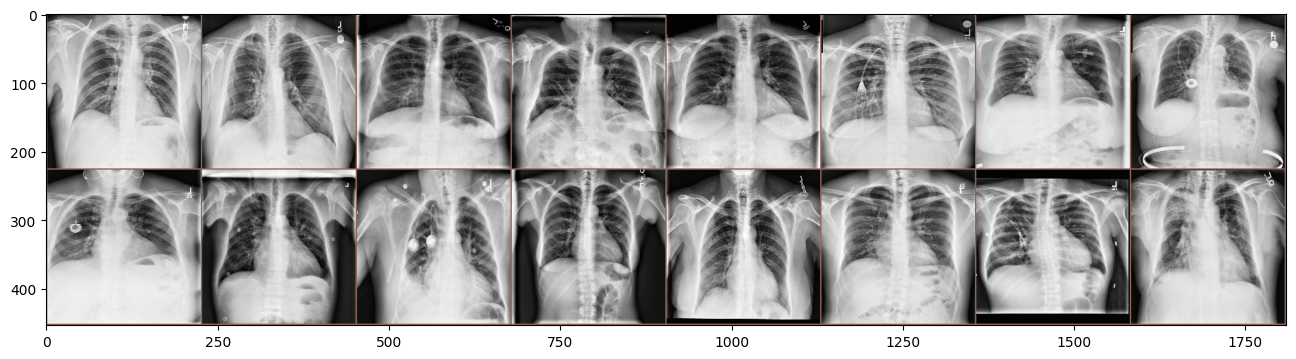

In [17]:
n_way = 2     
n_support = 5 
n_query = 3   
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_train, y_train)
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

### Train a Prototypical Network using a fine-tuned base model

In [18]:
model = prototypical_network.ProtoNet(densenet121_model, device)
model.to(device)

basic_learning_rate = 0.0005

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       
n_support = 3   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

filename = "DenseNet121-best-few-shot-model.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

Start training: 


Epoch 1 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1
	Train Loss: 10.707 | Train Acc: 58.25%
	 Val. Loss: 14.262 | Val. Acc: 57.25%


Epoch 2 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 2
	Train Loss: 9.494 | Train Acc: 60.50%
	 Val. Loss: 11.689 | Val. Acc: 56.50%


Epoch 3 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 3
	Train Loss: 11.654 | Train Acc: 55.00%
	 Val. Loss: 11.481 | Val. Acc: 58.25%


Epoch 4 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 4
	Train Loss: 10.795 | Train Acc: 56.75%
	 Val. Loss: 12.562 | Val. Acc: 58.00%


Epoch 5 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 5
	Train Loss: 10.047 | Train Acc: 59.25%
	 Val. Loss: 11.708 | Val. Acc: 59.50%


Epoch 6 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 6
	Train Loss: 11.210 | Train Acc: 55.50%
	 Val. Loss: 11.758 | Val. Acc: 58.50%


Epoch 7 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7
	Train Loss: 10.500 | Train Acc: 61.00%
	 Val. Loss: 11.033 | Val. Acc: 60.00%


Epoch 8 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 8
	Train Loss: 11.654 | Train Acc: 58.50%
	 Val. Loss: 12.665 | Val. Acc: 57.25%


Epoch 9 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 9
	Train Loss: 10.004 | Train Acc: 59.00%
	 Val. Loss: 11.434 | Val. Acc: 56.75%


Epoch 10 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 10
	Train Loss: 11.188 | Train Acc: 57.75%
	 Val. Loss: 9.999 | Val. Acc: 64.75%


Epoch 11 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11
	Train Loss: 10.365 | Train Acc: 58.75%
	 Val. Loss: 12.308 | Val. Acc: 59.50%


Epoch 12 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12
	Train Loss: 8.916 | Train Acc: 62.50%
	 Val. Loss: 11.903 | Val. Acc: 58.00%


Epoch 13 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13
	Train Loss: 10.274 | Train Acc: 61.75%
	 Val. Loss: 11.839 | Val. Acc: 56.50%


Epoch 14 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14
	Train Loss: 10.252 | Train Acc: 63.00%
	 Val. Loss: 9.716 | Val. Acc: 62.00%


Epoch 15 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 15
	Train Loss: 9.459 | Train Acc: 61.75%
	 Val. Loss: 13.402 | Val. Acc: 60.00%


Epoch 16 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 16
	Train Loss: 10.587 | Train Acc: 58.50%
	 Val. Loss: 12.860 | Val. Acc: 60.00%


Epoch 17 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17
	Train Loss: 10.385 | Train Acc: 61.25%
	 Val. Loss: 10.925 | Val. Acc: 61.00%


Epoch 18 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 18
	Train Loss: 11.295 | Train Acc: 58.50%
	 Val. Loss: 11.697 | Val. Acc: 57.50%


Epoch 19 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 19
	Train Loss: 11.019 | Train Acc: 58.00%
	 Val. Loss: 10.503 | Val. Acc: 60.75%


Epoch 20 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 20
	Train Loss: 9.835 | Train Acc: 58.25%
	 Val. Loss: 10.259 | Val. Acc: 60.50%


In [19]:
results = {
    "Epoch": list(range(1, max_epoch + 1)),
    "Train Loss": train_loss_list,
    "Train Accuracy": train_accuracy_list,
    "Validation Loss": validation_loss_list,
    "Validation Accuracy": validation_accuracy_list
}

df = pd.DataFrame(results)


df.to_csv("/kaggle/working/densenet121_model_training_results.csv", index=False)
df.to_pickle("/kaggle/working/densenet121_model_training_results.pkl")

In [20]:
img_height, img_width = 224, 224
data_dir = test_data_dir
selected_classes = ['Covid19', 'Effusion']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=False
)

### 2 Way 3 Shot DenseNet121 Testing

In [21]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 6.292, Accuracy: 0.75
Episode: 100 ---> Loss: 3.998, Accuracy: 0.80
Episode: 200 ---> Loss: 2.515, Accuracy: 0.90
Episode: 300 ---> Loss: 10.514, Accuracy: 0.80
Episode: 400 ---> Loss: 14.777, Accuracy: 0.60
Episode: 500 ---> Loss: 4.331, Accuracy: 0.80
Episode: 600 ---> Loss: 0.260, Accuracy: 0.95
Episode: 700 ---> Loss: 16.717, Accuracy: 0.60
Episode: 800 ---> Loss: 0.801, Accuracy: 0.90
Episode: 900 ---> Loss: 5.865, Accuracy: 0.70
Episode: 1000 ---> Loss: 8.600, Accuracy: 0.75
Episode: 1100 ---> Loss: 2.720, Accuracy: 0.85
Episode: 1200 ---> Loss: 8.039, Accuracy: 0.55
Episode: 1300 ---> Loss: 3.518, Accuracy: 0.80
Episode: 1400 ---> Loss: 13.475, Accuracy: 0.55
Episode: 1500 ---> Loss: 5.289, Accuracy: 0.80
Episode: 1600 ---> Loss: 1.507, Accuracy: 0.95
Episode: 1700 ---> Loss: 6.906, Accuracy: 0.65
Episode: 1800 ---> Loss: 8.850, Accuracy: 0.45
Episode: 1900 ---> Loss: 8.912, Accuracy: 0.65
Episode: 2000 ---> Loss:

In [22]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}

df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_densenet121_model_2way_3shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_densenet121_model_2way_3shot.csv")

Test results saved to /kaggle/working/prototypical_model_test_results_densenet121_model_2way_3shot.csv


### 2 Way 3 Shot DenseNet121 Prediction

Class labels sampled: ['Effusion' 'Covid19']
{'loss': 6.6456451416015625, 'acc': 0.7666667103767395, 'y_hat': tensor([[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


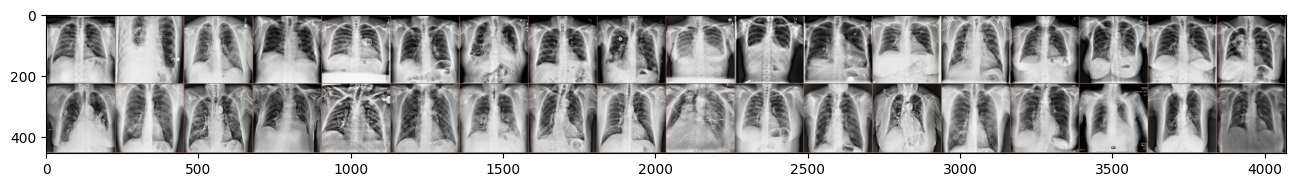

In [23]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 15 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [24]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data)

df_results.to_csv('/kaggle/working/prototypical_model_results_densenet121_2way_3shot.csv', index=False)

print("Results saved to /kaggle/working/prototypical_model_results_densenet121_2way_3shot.csv")

Results saved to /kaggle/working/prototypical_model_results_densenet121_2way_3shot.csv


### Classification Report

In [25]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    Effusion       0.79      0.73      0.76        15
     Covid19       0.75      0.80      0.77        15

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.77        30
weighted avg       0.77      0.77      0.77        30



### ROC Cuve

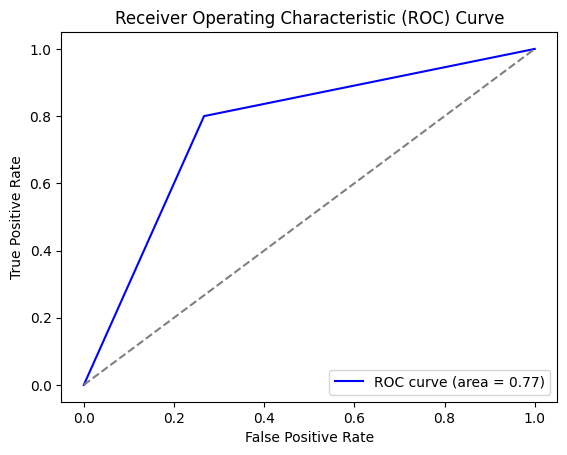

In [26]:
y_true_flat = results["y_true"].flatten() 
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

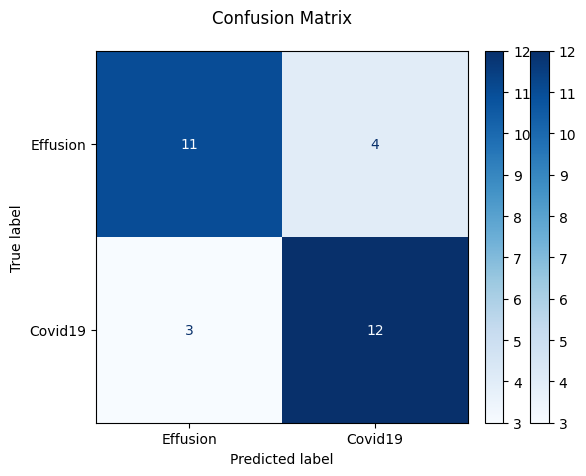

In [27]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### 2 Way 5 Shot DenseNet121 Testing

In [28]:
n_way = 2
n_support = 5
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 6.622, Accuracy: 0.80
Episode: 100 ---> Loss: 4.847, Accuracy: 0.70
Episode: 200 ---> Loss: 9.620, Accuracy: 0.70
Episode: 300 ---> Loss: 0.945, Accuracy: 0.85
Episode: 400 ---> Loss: 4.092, Accuracy: 0.80
Episode: 500 ---> Loss: 14.149, Accuracy: 0.50
Episode: 600 ---> Loss: 13.552, Accuracy: 0.55
Episode: 700 ---> Loss: 6.398, Accuracy: 0.75
Episode: 800 ---> Loss: 4.129, Accuracy: 0.75
Episode: 900 ---> Loss: 3.583, Accuracy: 0.90
Episode: 1000 ---> Loss: 1.389, Accuracy: 0.75
Episode: 1100 ---> Loss: 0.973, Accuracy: 0.80
Episode: 1200 ---> Loss: 7.425, Accuracy: 0.70
Episode: 1300 ---> Loss: 5.917, Accuracy: 0.70
Episode: 1400 ---> Loss: 3.789, Accuracy: 0.80
Episode: 1500 ---> Loss: 2.311, Accuracy: 0.80
Episode: 1600 ---> Loss: 5.839, Accuracy: 0.75
Episode: 1700 ---> Loss: 1.121, Accuracy: 0.90
Episode: 1800 ---> Loss: 9.581, Accuracy: 0.75
Episode: 1900 ---> Loss: 2.461, Accuracy: 0.85
Episode: 2000 ---> Loss: 2

In [29]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}

df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_densenet121_model_2way_5shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_densenet121_model_2way_5shot.csv")

Test results saved to /kaggle/working/prototypical_model_test_results_densenet121_model_2way_5shot.csv


### 2 Way 5 Shot DenseNet121 Prediction

Class labels sampled: ['Covid19' 'Effusion']
{'loss': 8.018234252929688, 'acc': 0.7799999713897705, 'y_hat': tensor([[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
         0],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]]), 'y_pred': array([[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0],
       [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0]])}


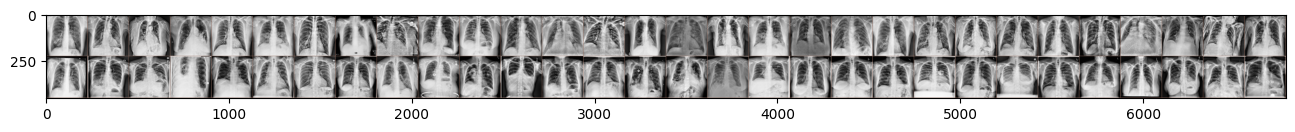

In [30]:
prototypical_model.to(device)
n_way = 2
n_support = 5
n_query = 25 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [31]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data)

df_results.to_csv('/kaggle/working/prototypical_model_results_densenet121_model_2way_5shot.csv', index=False)

print("Results saved to /kaggle/working/prototypical_model_results_densenet121_model_2way_5shot.csv")

Results saved to /kaggle/working/prototypical_model_results_densenet121_model_2way_5shot.csv


### Classification Report

In [32]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Covid19       0.82      0.72      0.77        25
    Effusion       0.75      0.84      0.79        25

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50



### ROC Curve

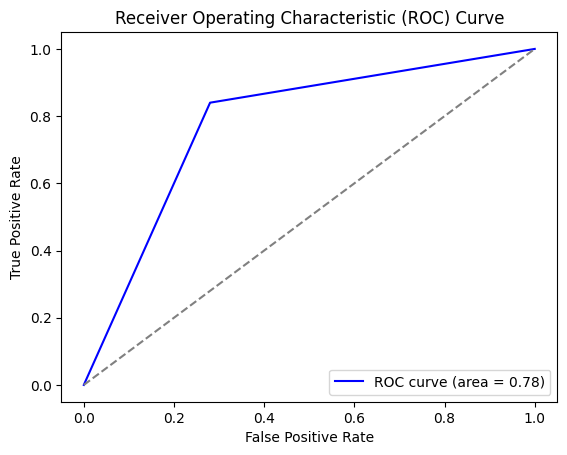

In [33]:
y_true_flat = results["y_true"].flatten()  
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

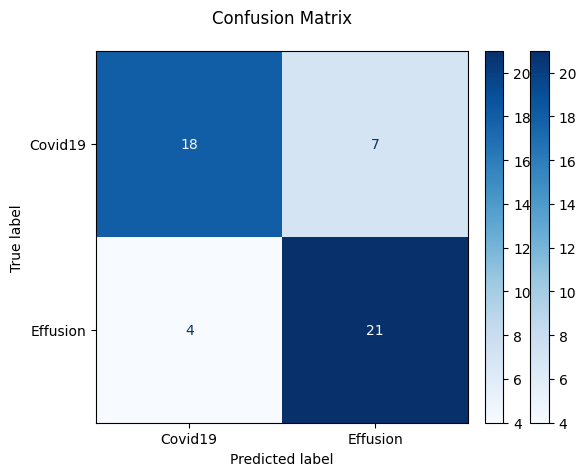

In [34]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [35]:
img_height, img_width = 224, 224
data_dir = test_data_dir
selected_classes = ['Covid19', 'Effusion','Pneumonia']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=False
)
x_test.shape,y_test.shape

((90, 224, 224, 3), (90,))

### 3 Way 5 Shot DenseNet121 Testing

In [36]:
n_way = 3
n_support = 5
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 11.138, Accuracy: 0.50
Episode: 100 ---> Loss: 8.487, Accuracy: 0.73
Episode: 200 ---> Loss: 11.490, Accuracy: 0.53
Episode: 300 ---> Loss: 4.704, Accuracy: 0.63
Episode: 400 ---> Loss: 7.738, Accuracy: 0.57
Episode: 500 ---> Loss: 11.431, Accuracy: 0.60
Episode: 600 ---> Loss: 8.112, Accuracy: 0.67
Episode: 700 ---> Loss: 10.813, Accuracy: 0.47
Episode: 800 ---> Loss: 20.850, Accuracy: 0.57
Episode: 900 ---> Loss: 6.544, Accuracy: 0.60
Episode: 1000 ---> Loss: 14.508, Accuracy: 0.50
Episode: 1100 ---> Loss: 8.316, Accuracy: 0.53
Episode: 1200 ---> Loss: 10.086, Accuracy: 0.57
Episode: 1300 ---> Loss: 8.486, Accuracy: 0.63
Episode: 1400 ---> Loss: 9.409, Accuracy: 0.40
Episode: 1500 ---> Loss: 15.209, Accuracy: 0.50
Episode: 1600 ---> Loss: 20.230, Accuracy: 0.50
Episode: 1700 ---> Loss: 6.396, Accuracy: 0.57
Episode: 1800 ---> Loss: 15.049, Accuracy: 0.63
Episode: 1900 ---> Loss: 10.810, Accuracy: 0.47
Episode: 2000 ---

In [37]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}

df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_densenet121_model_3way_5shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_densenet121_model_3way_5shot.csv")

Test results saved to /kaggle/working/prototypical_model_test_results_densenet121_model_3way_5shot.csv


### 3 Way 5 Shot DenseNet121 Prediction

In [39]:
n_way = 3
n_support = 5
n_query = 10 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

OutOfMemoryError: CUDA out of memory. Tried to allocate 70.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 50.12 MiB is free. Process 2619 has 14.69 GiB memory in use. Of the allocated memory 868.54 MiB is allocated by PyTorch, and 99.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data)

df_results.to_csv('/kaggle/working/prototypical_model_results_densenet121_model_3way_5shot.csv', index=False)

print("Results saved to /kaggle/working/prototypical_model_results_densenet121_model_3way_5shot.csv")

### Classification Report

In [ ]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### ROC Curve

In [ ]:
y_true_flat = results["y_true"].flatten()  
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()